In [1]:
from imaster_paper_args import *

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid1807877/


In [2]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt

import pyccl as ccl
import pymaster as nmt
import healpy as hp

In [3]:
path = os.path.join(os.path.dirname(os.environ['SCRATCH']), 
                    'share/raytracesim/HSC_S16A/mocks_4zbins')

In [4]:
i = 25
rot = 9
sims = [os.path.join(path, sim) for sim in os.listdir(path) if f'r{i:03d}_rot{rot:02d}' in sim]

In [5]:
sim_dict = {}
for i, sim in enumerate(sims):
    # Remove objects with z = -1
    sim = fits.open(sim)[1].data
    sim = sim[sim['z_source_mock'] != -1]

    # Get z centers and boundary
    z = np.unique(sim['z_source_mock'])
    z_edges = 0.5 * (z[1:] + z[:-1])
    z_edges = np.concatenate([[0], z_edges, [np.max(z)+0.2]])
    dNdz, _ = np.histogram(sim['z_source_mock'], bins=z_edges, density=True)
    sim_dict[i] = {
        'z': z,
        'dNdz': dNdz,
        'ra': sim['ra_mock'],
        'dec': sim['dec_mock'],
        'e1': sim['e1_mock'],
        'e2': sim['e2_mock'],
        'g1': sim['shear1_sim'],
        'g2': sim['shear2_sim']
    }

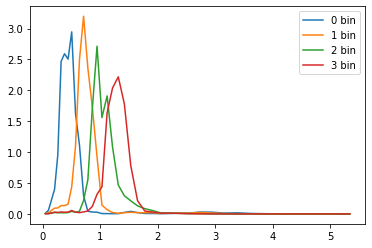

In [6]:
for b in sim_dict.keys():
    sim = sim_dict[b]
    plt.plot(sim['z'], sim['dNdz'], label=f'{b} bin')
plt.legend()

# NaMaster

In [7]:
sim = sim_dict[0]

In [8]:
nside = 128
npix = hp.nside2npix(nside)
pixels = hp.ang2pix(nside, sim['ra'], sim['dec'], lonlat=True)

In [9]:
cosmo = ccl.Cosmology(Omega_c=0.233, Omega_b=0.046, h=0.7, n_s=0.97, sigma8=0.82)
ell = np.arange(3 * nside)

In [10]:
tracers = [ccl.WeakLensingTracer(cosmo, (sim_dict[i]['z'], sim_dict[i]['dNdz'])) for i in range(len(sim_dict.keys()))]

In [11]:
cl_ccl = ccl.cls.angular_cl(cosmo, tracers[0], tracers[0], ell)

In [12]:
gamma1_map = np.zeros(npix)
gamma2_map = np.zeros(npix)
counts_map = np.zeros(npix)

gamma1_map[pixels] += sim['g1']
gamma2_map[pixels] += sim['g2']
counts_map[pixels] += np.ones_like(sim['g2'])

gamma1_map[counts_map >0] = np.divide(gamma1_map[counts_map >0], counts_map[counts_map >0])
gamma2_map[counts_map >0] = np.divide(gamma2_map[counts_map >0], counts_map[counts_map >0])

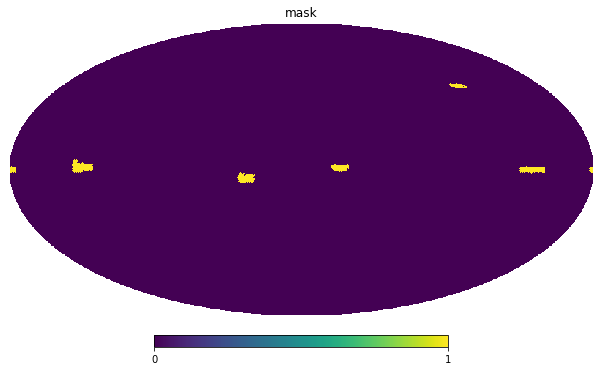

In [13]:
hp.mollview(counts_map, title='mask')

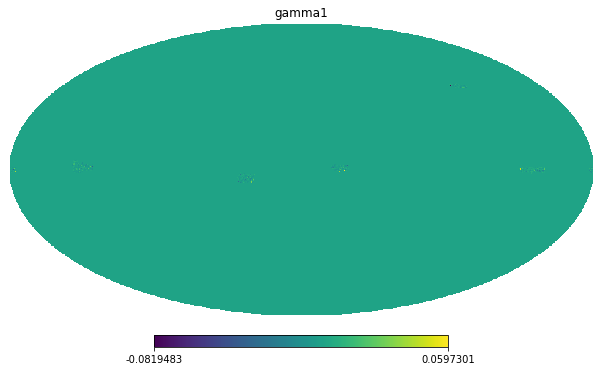

In [14]:
hp.mollview(gamma1_map, title='gamma1')

In [15]:
mask = counts_map

In [16]:
f_2 = nmt.NmtField(mask, [gamma1_map, gamma2_map])
b = nmt.NmtBin.from_nside_linear(nside, 1)
ell_arr = b.get_effective_ells()
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f_2, f_2, b)
D_l = w.couple_cell(np.array([
    cl_ccl, np.zeros_like(cl_ccl), np.zeros_like(cl_ccl), np.zeros_like(cl_ccl)
]))
D_l_nmt = nmt.compute_coupled_cell(f_2, f_2)

In [17]:
D_l_hp = hp.sphtfunc.anafast([gamma1_map*0, gamma1_map, gamma2_map], lmax=3*nside-1, pol=True)

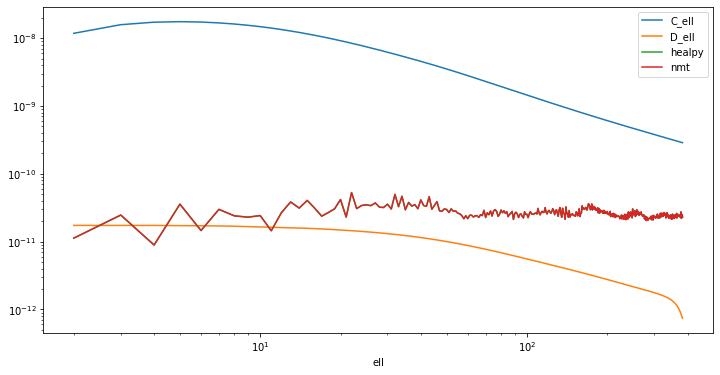

In [18]:
plt.figure(figsize=(12, 6))
plt.loglog(ell_arr, cl_ccl[2:], label='C_ell')
plt.loglog(ell_arr, D_l[0][2:], label='D_ell')
plt.loglog(ell_arr, D_l_hp[1][2:], label='healpy')
plt.loglog(ell_arr, D_l_nmt[0][2:], label='nmt')
plt.xlabel('ell')
plt.legend()

In [19]:
cl_nmt = w.decouple_cell(D_l_nmt)

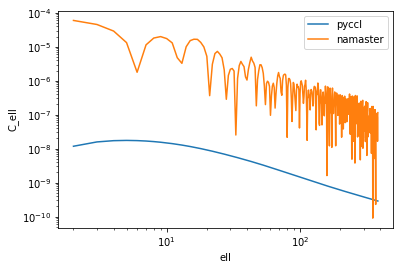

In [20]:
plt.loglog(ell_arr, cl_ccl[2:], label='pyccl')
plt.loglog(ell_arr, np.abs(cl_nmt[0]), label='namaster')
plt.xlabel('ell')
plt.ylabel('C_ell')
plt.legend()

# noise = sigma_e ** 2 / n_eff / f_sky

In [21]:
nside=128
    
use_window=True
unit_window=False

do_pseudo_cl=True
do_xi=False

bin_cl=True
bin_xi=True

use_binned_l=False
use_binned_theta=False

store_win=True

In [22]:
shear_zbins=lsst_source_tomo_bins(nbins=1,use_window=use_window,nside=nside,f_sky=0.5,unit_win=unit_window)

ns0:  27.0
[0.10002001 0.10082017 0.10162032 ... 2.9981997  2.9989998  2.9998    ] 100 5
source_tomo_bins, zmax 5.0 2.9998 0.59997
Tracer utils has no tracers
skylens will use following default values:  {'yaml_inp_file': None, 'python_inp_file': None, 'l_cl': None, 'Ang_PS': None, 'logger': None, 'tracer_utils': None, 'shear_zbins': None, 'kappa_zbins': None, 'zkernel_func_names': {'shear': 'set_kernel', 'galaxy': 'set_kernel', 'kappa': 'set_kernel'}, 'pk_params': {'non_linear': 1, 'kmax': 30, 'kmin': 0.0003, 'nk': 500, 'scenario': 'dmo', 'pk_func': 'camb_pk_too_many_z', 'halofit_version': 'takahashi'}, 'cosmo_params': {'h': 0.6774, 'Omb': 0.0486, 'Omd': 0.2589, 's8': 0.817, 'Om': 0.3075, 'Ase9': 2.2, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014901684739047072, 'w': -1, 'wa': 0, 'Tcmb': <Quantity 2.7255 K>, 'z_max': 4, 'use_astropy': True, 'Oml': 0.6925, 'astropy_cosmo': FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.7255 K, Neff=3.046, m_

/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:33: RuntimeWarning: divide by zero encountered in true_divide


power spectra function:  <bound method Power_Spectra.camb_pk_too_many_z of <skylens.power_spectra.Power_Spectra object at 0x14577640c880>>
Win gen: step size 19 384 31.0 10 False True
Window done. Size: 0.0


/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:123: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl_tomo, Win: None
cl graph done
gather_dict got empty dictionary


In [23]:
shear_zbins.keys()

dict_keys(['SN', 0, 'n_bins', 'zmax', 'zp', 'zs', 'pz', 'z_bins', 'zp_sigma', 'zp_bias', 'bias_func'])

In [24]:
shear_zbins[0].keys()

dict_keys(['z', 'dz', 'nz', 'ns', 'W', 'pz', 'pzdz', 'Norm', 'b1', 'bz1', 'AI', 'AI_z', 'mag_fact', 'shear_m_bias', 'lm', 'k_max', 'window_cl0', 'window', 'window_N'])

In [25]:
shear_zbins[0]['z'] = sim['z']
shear_zbins[0]['dz'] = np.gradient(sim['z'])
shear_zbins[0]['pz'] = sim['dNdz']
shear_zbins[0]['pzdz'] = sim['dNdz'] * np.gradient(sim['z'])

In [26]:
shear_zbins[0]['window'] = mask
shear_zbins[0]['window_N'] = mask

In [27]:
corrs = [corr_ll]
bi=(0,0)
corr=corrs[0]
s=s1_s2s[corr]
if corr==corr_ll:
    s=(2,-2)

In [28]:
#setup parameters
lmax_cl = 3 *nside - 1 #2000
lmin_cl = 0

l0=np.arange(lmin_cl,lmax_cl)

window_lmax= lmax_cl

lmin_cl_Bins=lmin_cl+2
lmax_cl_Bins=lmax_cl-10
Nl_bins=30

# l_bins=get_l_bins(l_min=lmin_cl_Bins,l_max=lmax_cl_Bins,N_bins=Nl_bins,binning_scheme='log',min_modes=1)#,binning_mode='decreasing')
# l_bins=l_bins[l_bins<=lmax_cl_Bins]
# l_bins0=l_bins*1.
l_bins=np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins+1)))
lb=.5*(l_bins[1:]+l_bins[:-1])
dl=(l_bins[1:]-l_bins[:-1])
lb_cl=lb*1.
l_bins_center=lb*1
Nl_bins=len(lb)

# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
l=l0

In [29]:
Skylens_kwargs=parse_dict(locals())

Skylens_kwargs['do_pseudo_cl']=True
Skylens_kwargs['do_xi']=False
SL_cl0=Skylens(**Skylens_kwargs)

skylens will use following default values:  {'yaml_inp_file': None, 'python_inp_file': None, 'use_defaults': None, 'l_cl': None, 'Ang_PS': None, 'logger': None, 'kappa_zbins': None, 'galaxy_zbins': None, 'zkernel_func_names': {'shear': 'set_kernel', 'galaxy': 'set_kernel', 'kappa': 'set_kernel'}, 'pk_params': {'non_linear': 1, 'kmax': 30, 'kmin': 0.0003, 'nk': 500, 'scenario': 'dmo', 'pk_func': 'camb_pk_too_many_z', 'halofit_version': 'takahashi'}, 'cosmo_params': {'h': 0.6774, 'Omb': 0.0486, 'Omd': 0.2589, 's8': 0.817, 'Om': 0.3075, 'Ase9': 2.2, 'mnu': 0.06, 'Omk': 0.0, 'tau': 0.06, 'ns': 0.965, 'OmR': 0.0014901684739047072, 'w': -1, 'wa': 0, 'Tcmb': <Quantity 2.7255 K>, 'z_max': 4, 'use_astropy': True, 'Oml': 0.6925, 'astropy_cosmo': FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)}, 'WT_kwargs': None, 'WT': None, 'z_PS': None, 'log_z_PS': 2, 'window_l': None, 'Win': None, 'cl_func_names': {('galaxy', 

/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:33: RuntimeWarning: divide by zero encountered in true_divide


power spectra function:  <bound method Power_Spectra.camb_pk_too_many_z of <skylens.power_spectra.Power_Spectra object at 0x1457753ea1c0>>
Win gen: step size 100 383 384.0 1 True True
Win not found, computing now
get_Win, total cl keys:  1
set window_cl: cl0,cl_b done 0.00010752677917480469
set window_cl: cl done 0.026442766189575195 0.015000001 0.0
set_window_cl done 0.9403533935546875
wigner_files: {0: '/hildafs/projects/phy200017p/andypark/Skylens_public/temp/wig3j_l5000_w5000_0_reorder.zarr', 2: '/hildafs/projects/phy200017p/andypark/Skylens_public/temp/wig3j_l2200_w4400_2_reorder.zarr'}
wigner done dict_keys([])
setting windows, coupling matrices  <Client: 'tcp://127.0.0.1:38185' processes=1 threads=1, memory=51.56 GiB>
get_coupling_lm_all_win 0
got wig3j 0
done lm 0 4.181351900100708
get_coupling_lm_all_win 300
got wig3j 300
done lm 300 3.9285194873809814
get_coupling_lm_all_win 200
got wig3j 200
done lm 200 3.445857524871826
done combine lm 11.649946928024292
get_coupling_lm_all

In [30]:
clG = SL_cl0.cl_tomo()
cl0 = client.compute(clG['cl_b']).result()
pcl0 = client.compute(clG['stack']).result()

/hildafs/home/andypark/.local/lib/python3.9/site-packages/skylens-0.1-py3.9.egg/skylens/angular_power_spectra.py:123: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl_tomo, Win: {'cl': {('shear', 'shear'): {(0, 0): <Future: finished, type: dict, key: (0, 0)>}}}
cl graph done
gather_dict got empty dictionary


In [31]:
SL_cl0.gather_data()

gather_dict got empty dictionary


In [32]:
pseudo_cl = cl_ccl[:-1] @ SL_cl0.Win['cl'][corr_ll][bi]['M']

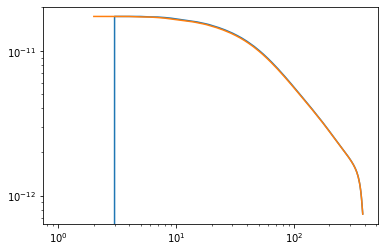

In [33]:
plt.loglog(ell[1:], pseudo_cl, label='D_l_skylens')
plt.loglog(ell_arr, D_l[0][2:], label='D_l_namaster')

Text(0, 0.5, 'D_l_namaster / D_l_skylens')

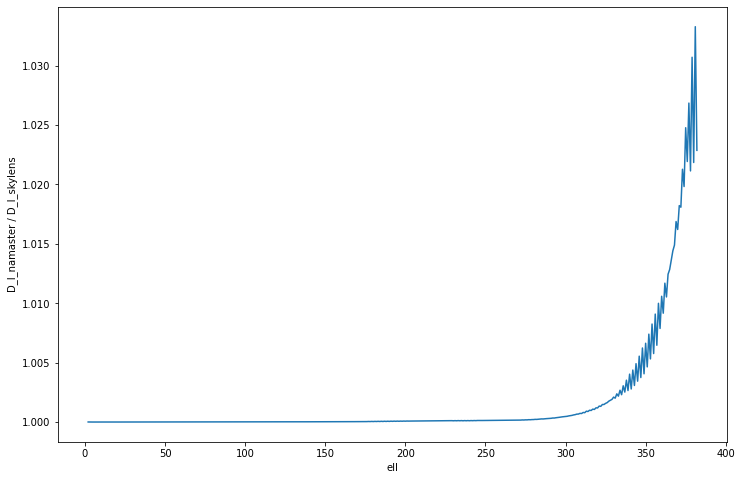

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(ell_arr[:-1], D_l[0][2:-1] / pseudo_cl[2:])
plt.xlabel('ell')
plt.ylabel('D_l_namaster / D_l_skylens')

In [35]:
test_mat = np.zeros((383, 27))
for i in np.arange(383):
    if bin_utils["bin_indx"][i] < 0 or bin_utils["bin_indx"][i] >= bin_utils["n_bins"]:
        continue
    test_mat[i, bin_utils["bin_indx"][i]] = 1.0

NameError: name 'bin_utils' is not defined

In [ ]:
SL_cl0.cl_bin_utils['binning_mat'] = test_mat
SL_cl0.cl_bin_utils['norm'] = np.dot(SL_cl0.cl_bin_utils['r_dr'], SL_cl0.cl_bin_utils['binning_mat'])

In [ ]:
binned_cl = SL_cl0.binning.bin_1d(cl_ccl[:-1], bin_utils)

In [ ]:
rdr = SL_cl0.cl_bin_utils["r_dr"]
r_dr_m = SL_cl0.cl_bin_utils["r_dr_m"][1]

In [ ]:
binning_mat = SL_cl0.cl_bin_utils['binning_mat'] * rdr[:, None] / SL_cl0.cl_bin_utils["norm"][None, :]

In [ ]:
binning_mat2 = cl_ccl[:-1, None] * SL_cl0.cl_bin_utils['binning_mat'] * binned_cl

In [ ]:
binned_M = binning_mat.T @ M @ binning_mat2

In [ ]:
binningg = binning()

In [ ]:
bu = SL_cl0.cl_bin_utils

In [ ]:
bu["r_dr_m"] = {}
bu["norm_m"] = {}
ls = ["i", "j", "k", "l", "m"]
for ndim in [1, 2]:
    s1 = ls[0]
    s2 = ls[0]
    r_dr_m = np.copy(bu["r_dr"])
    norm_m = np.copy(bu["norm"])
    for i in np.arange(ndim - 1):
        s1 = s2 + "," + ls[i + 1]
        s2 += ls[i + 1]
        r_dr_m = np.einsum(
            s1 + "->" + s2, r_dr_m, bu["r_dr"]
        )  # works ok for 2-d case
        norm_m = np.einsum(
            s1 + "->" + s2, norm_m, bu["norm"]
        )  # works ok for 2-d case
    bu["r_dr_m"][ndim] = r_dr_m
    bu["norm_m"][ndim] = norm_m

In [ ]:
binned_Dl = binningg.bin_1d(D_l_hp[1][:-1], bu)

In [ ]:
binned_M.shape

In [ ]:
D_l_hp.shape

In [ ]:
M = SL_cl0.Win['cl'][corr_ll][bi]['M']

In [ ]:
pseudo_cl_noise = ((sigma_e ** 2 / N_eff) * np.ones_like(l)).dot(M_noise)

In [ ]:
SL_cl0.Win['cl'][corr_ll][bi].keys()

In [ ]:
plt.figure(figsize=(15, 8))
plt.loglog(ell_arr, cl_ccl[2:], label='C_ell_theory')
plt.loglog(ell_arr, D_l[0][2:], label='D_ell_theory')
#plt.loglog(ell_arr, D_l_hp[1][2:], label='healpy')
plt.loglog(ell_arr, D_l_nmt[0][2:], label='D_ell_namaster')
plt.loglog(ell_arr, np.abs(cl_nmt[0]), label='C_ell_namaster')
plt.xlabel('ell')
plt.legend()

In [ ]:
binned_cl

In [ ]:
binned_cl_data = binned_Dl @ np.linalg.inv(binned_M)

In [ ]:
binned_M @ binned_Dl

In [ ]:
binned_cl_data